In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Uncertain Isocontours
This notebook implements the work of Pöthkow et. al [<sup id="fn1-back">1</sup>](#fn1)

[<sup id="fn1">1</sup>](#fn1-back): Pothkow und Hege, „Positional Uncertainty of Isocontours“.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy import special
import ipywidgets
from ipywidgets import interact, interact_manual

## Model

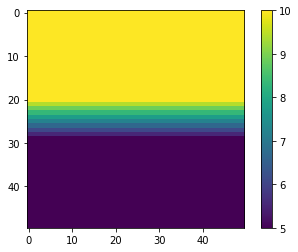

In [3]:
model = np.zeros((50,50))

model[:20,:] = 10.
model[20:30,:] = np.transpose([np.linspace(10,5,10)]*50)
model[30:,:] = 5.

plt.figure()
plt.imshow(model)
plt.colorbar()
plt.show()

## Probability density function
\begin{align}
    {\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}
\end{align}

In [4]:
def normal(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - 0.5 * ( (x - mu)/sigma )**2 )

In [5]:
def generate_normal(i, j, m1=15., m2=7., var=1.):
    mu = np.zeros((50,50))
    mu[:20,:] = m1
    mu[20:30,:] = np.transpose([np.linspace(m1,m2,10)]*50)
    mu[30:,:] = m2
    
    variance = np.ones((50,50)) * var
    
    return mu, variance

In [9]:
mean = np.empty((50,50))
variance = np.empty((50,50))
sample = np.empty((50,50))
@interact(
    mean1=(1.,10.), 
    mean2=(1.,10.), 
    var=(1e-9,3), 
)
def generate_sample(mean1=10., mean2=7., var=1.):
    global mean
    global variance
    global sample
    
    x = np.arange(50)
    y = np.arange(50)
    xx, yy = np.meshgrid(x, y)

    mean, variance = generate_normal(xx, yy, mean1, mean2, var)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('Mean $\mu$')
    plt.imshow(mean)
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title('Variance $\sigma^2$')
    plt.imshow(variance)
    plt.colorbar()
    plt.show()

    sample = np.random.normal(mean, variance)
    
    plt.figure(figsize=(18,6))
    plt.title('realization')
    plt.imshow(sample)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='mean1', max=10.0, min=1.0), FloatSlider(value=7.0, …

# Isocontour Density
$$
    g_\theta (x) = \frac{1}{\sigma(x)\sqrt{2\pi}} exp \left( - \frac{1}{2} \left( \frac{\theta - \mu(x)}{\sigma(x)} \right)^2 \right)
$$

The value of the function is related to the numerical condition of isocontour extraction. In other words, how sensitive is the extraction of the isocontour to small pertubations $d t$ based on the normal distribution.

In [10]:
def g(contour, mean, variance):
    inner = - 0.5 * ( (contour - mean) / variance)**2
    denumerator = variance * np.sqrt(2 * np.pi)
    return np.exp(inner)/denumerator

In [11]:
@interact(
    sample=ipywidgets.fixed(sample), 
    mean=ipywidgets.fixed(mean),
    variance=ipywidgets.fixed(variance),
    contour=(1e-9,15.)
)
def generate_icd(sample=sample, mean=mean, variance=variance, contour=10.):
    icd = g(contour, mean, variance)
    
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('realization & contour')
    plt.imshow(sample)
    plt.colorbar()
    plt.contour(sample, levels=[contour], colors='r')
    plt.subplot(1,2,2)
    plt.title('ICD & contour')
    plt.imshow(icd)
    plt.colorbar()
    plt.contour(sample, levels=[contour], colors='r')
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='contour', max=15.0, min=1e-09), Output()), _dom_cla…

# Level-Crossing Probability Field
$$
    P_\theta (x) = \frac{1}{2} \left( 1 - Erf \left( \frac{\mu(x) - \theta}{\sqrt{2} \sigma(x)} \right) \right)
$$

The value of the function can be interpreted as the probability of two independend realizations $y_a$ and $y_b$ of a random variable to be greater or equal to $\theta$, while the other is smaller or equal to $\theta$. In other words, how likely two independend realizations fullfill the fact that one is greater (or equal) and the other at the same time smaller (or equal) to $\theta$.

In [12]:
def lcp(contour, mean, variance):
    inner = (mean - contour) / (np.sqrt(2)*variance)
    return 0.5 * ( 1 - special.erf(inner) )

In [13]:
@interact(
    sample=ipywidgets.fixed(sample), 
    mean=ipywidgets.fixed(mean),
    variance=ipywidgets.fixed(variance),
    contour=(1e-9,15.)
)
def generate_icd(sample=sample, mean=mean, variance=variance, contour=10.):
    LCP = lcp(contour, mean, variance)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('realization & contour')
    plt.imshow(sample)
    plt.colorbar()
    plt.contour(sample, levels=[contour], colors='r')
    plt.subplot(1,2,2)
    plt.title('LCP & contour')
    plt.imshow(LCP)
    plt.colorbar()
    plt.contour(sample, levels=[contour], colors='r')
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='contour', max=15.0, min=1e-09), Output()), _dom_cla…